In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Load the datasets
from google.colab import drive
drive.mount('/content/drive')
Data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/listingsSeattle.csv')
Data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/listingsBoston.csv')

#Initial check
#print(Data1.head(5))
#print(Data2.head(5))
#print(Data1.info())
#print(Data2.info())
#print(Data1.isnull().sum())
#print(Data2.isnull().sum())
#print(Data1.duplicated().sum())
#print(Data2.duplicated().sum())


#Preprocessing
#Dataset 1
#Identify Numerical & Categorical Columns
NumericalData1 = Data1.select_dtypes(include=['float64', 'int64']).columns
CategoricalData1 = Data1.select_dtypes(include=['object']).columns

#Fill Missing Values in Numerical & Categorical Columns
Data1[NumericalData1] = Data1[NumericalData1].apply(lambda x: x.fillna(x.median()))
Data1[CategoricalData1] = Data1[CategoricalData1].apply(lambda x: x.fillna(x.mode([0])))

#Dataset 2
#Identify Numerical & Categorical Columns
NumericalData2 = Data2.select_dtypes(include=['float64', 'int64']).columns
CategoricalData2 = Data2.select_dtypes(include=['object']).columns

#Fill Missing Values in Numerical & Categorical Columns
Data2[NumericalData2] = Data2[NumericalData2].apply(lambda x: x.fillna(x.median()))
Data2[CategoricalData2] = Data2[CategoricalData2].apply(lambda x: x.fillna(x.mode([0])))

#print(Data1.isnull().sum())
#print(Data2.isnull().sum())

Mounted at /content/drive


In [ ]:
#Drop irrelevant columns
Irrelevent = ['neighbourhood_group_cleansed', 'license', 'jurisdiction_names']
Data1 = Data1.drop(columns=[col for col in Irrelevent if col in Data1.columns], errors='ignore')
Data2 = Data2.drop(columns=[col for col in Irrelevent if col in Data2.columns], errors='ignore')
#print(Data1.columns)
#print(Data2.columns)


#Convert Data Types
def NumericConverter(df, columns):
  for col in columns:
    df[col] = df[col].replace({'\$': '', ',': ''}, regex = True)   #Remove signs
    df[col] = pd.to_numeric(df[col], errors='coerce')              #Convert to numeric
  return df

#Columns to convert to numeric
Price = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee']
Data1 = NumericConverter(Data1, Price)
Data2 = NumericConverter(Data2, Price)
#print(Data1.dtypes)
#print(Data2.dtypes)


#Handle outliers
def Outliers(df, columns):
  for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LowerBound = Q1 - 1.5 * IQR
    UpperBound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(LowerBound, UpperBound)
  return df

#Apply outlier handling to price columns
Data1 = Outliers(Data1, Price)
Data2 = Outliers(Data2, Price)
#print(Data1.describe())
#print(Data2.describe())

In [ ]:
#Standardize Formatting
#Convert datetime columns
Data1['host_since'] = pd.to_datetime(Data1['host_since'])
Data2['host_since'] = pd.to_datetime(Data2['host_since'])
Data1['last_scraped'] = pd.to_datetime(Data1['last_scraped'])
Data2['last_scraped'] = pd.to_datetime(Data2['last_scraped'])

#Standardize categorical columns
CategoricalColumns = ['room_type', 'cancellation_policy', 'bed_type', 'instant_bookable']
for col in CategoricalColumns:
  Data1[col] = Data1[col].str.lower()
  Data2[col] = Data2[col].str.lower()

#print(Data1[['last_scraped', 'host_since']].head(5))
#print(Data2[['last_scraped', 'host_since']].head(5))
#print(Data1[CategoricalColumns].head(5))
#print(Data2[CategoricalColumns].head(5))


#Combine the datasets
CombinedData = pd.concat([Data1, Data2], ignore_index=True)

#Second check
#print(CombinedData.info())
#print(CombinedData.head(10))

In [ ]:
#Preprocessing (handle missing values in combined data)

#Step 1: Impute numerical columns with median
NumericalColumns = CombinedData.select_dtypes(include=['float64' ,'int64']).columns
CombinedData[NumericalColumns] = CombinedData[NumericalColumns].fillna(CombinedData[NumericalColumns].median())

#Step 2: Impute categorical columns with 'Unknown'
CategoricalColumns = CombinedData.select_dtypes(include=['object']).columns
CombinedData[CategoricalColumns] = CombinedData[CategoricalColumns].fillna('Unknown')

#Step3: Drop columns with many missing values
Threshold = 0.5             #50% missing values
CombinedData = CombinedData.dropna(axis=1, thresh=int(Threshold * len(CombinedData)))

#Step4: Drop rows with crucial missing values
CombinedData = CombinedData.dropna(subset=['price', 'latitude', 'longitude'])

#Check
print(CombinedData.info())
print(CombinedData.isnull().sum())
#Data is clear: 7403 rows * 92 columns and there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                7403 non-null   int64         
 1   listing_url                       7403 non-null   object        
 2   scrape_id                         7403 non-null   int64         
 3   last_scraped                      7403 non-null   datetime64[ns]
 4   name                              7403 non-null   object        
 5   summary                           7403 non-null   object        
 6   space                             7403 non-null   object        
 7   description                       7403 non-null   object        
 8   experiences_offered               7403 non-null   object        
 9   neighborhood_overview             7403 non-null   object        
 10  notes                             7403 non-null 

In [ ]:
#Calculation of descriptive statistics
#For numerical columns
NumericalColumns = CombinedData.select_dtypes(include=['float64' ,'int64']).columns
DescriptiveStatistics = CombinedData[NumericalColumns].describe()
print(DescriptiveStatistics)

#For non-numerical columns (just important columns)
ImportantCategorical = ['room_type', 'cancellation_policy', 'instant_bookable']
Mode = CombinedData[ImportantCategorical].mode().iloc[0]     #most frequent value
Frequency = CombinedData[ImportantCategorical].apply(lambda x: x.value_counts())
Prportions = CombinedData[ImportantCategorical].apply(lambda x: x.value_counts(normalize=True))
print("\nMode Values:\n", Mode)
print("\nFrequency Counts:\n", Frequency)
print("\nProportions:\n", Prportions)

                 id     scrape_id       host_id  host_listings_count  \
count  7.403000e+03  7.403000e+03  7.403000e+03          7403.000000   
mean   6.950001e+06  2.016049e+13  2.021053e+07            32.214102   
std    4.052397e+06  4.009296e+08  1.962309e+07           123.569529   
min    3.335000e+03  2.016010e+13  4.193000e+03             0.000000   
25%    3.864100e+06  2.016010e+13  4.343164e+06             1.000000   
50%    7.035240e+06  2.016010e+13  1.448650e+07             1.000000   
75%    9.500804e+06  2.016091e+13  3.028359e+07             4.000000   
max    1.493346e+07  2.016091e+13  9.385411e+07           749.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                7403.000000  7403.000000  7403.000000   7403.000000   
mean                   32.214102    45.067727   -97.515448      3.200189   
std                   123.569529     2.643568    25.613198      1.890166   
min                     0.000000    42.235942  

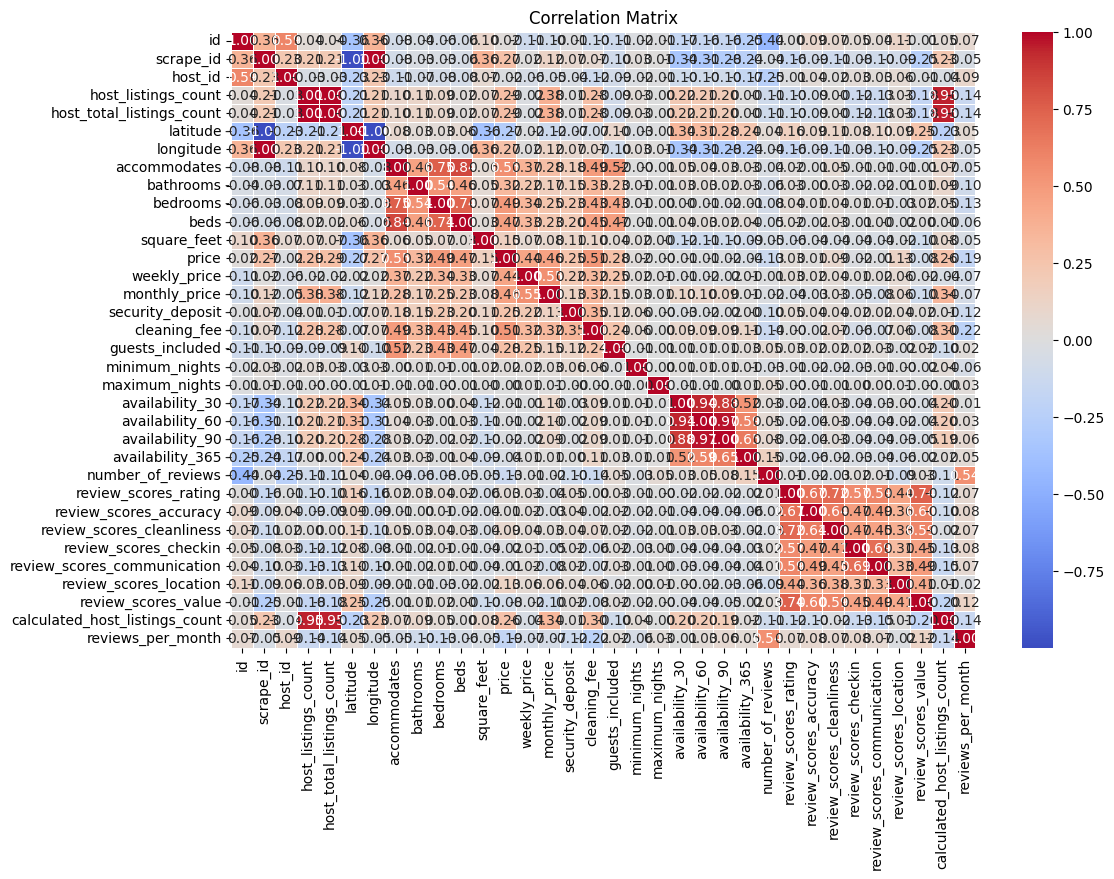

In [ ]:
#Correlations Between Variables
CorrelationMatrix = CombinedData[NumericalColumns].corr()
#print(CorrelationMatrix)

#Visualize the results
plt.figure(figsize=(12,8))
sns.heatmap(CorrelationMatrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<ipython-input-7-9e4a8970266a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TimeData['year'] = TimeData['host_since'].dt.year


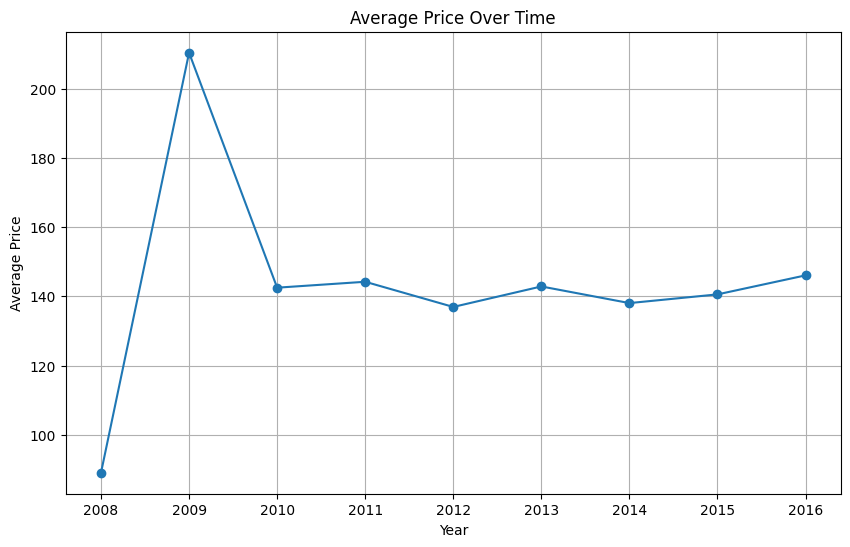

In [ ]:
#Detection and Visualization of Trends Over Time

TimeData = CombinedData[['host_since', 'price']]
TimeData['year'] = TimeData['host_since'].dt.year
AveragePrice = TimeData.groupby('year')['price'].mean()

plt.figure(figsize=(10,6))
plt.plot(AveragePrice.index, AveragePrice.values, marker='o', linestyle='-')
plt.title('Average Price Over Time')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

In [ ]:
#Check the trend correctness by considering spike in prices in 2009

#1-Data Cleanliness

#Check the NaN values
MissingData = CombinedData[['host_since', 'price']].isnull().sum()
#Check negative or unrealistic prices
IncorrectPrices = CombinedData[CombinedData['price'] < 0]

print("Missing Data:\n", MissingData)
print("\nIncorrect Prices:\n", IncorrectPrices)

Missing Data:
 host_since    2
price         0
dtype: int64

Incorrect Prices:
 Empty DataFrame
Columns: [id, listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, square_feet, price, weekly_price, monthly_price, security_deposit, cleaning_fee, guests_included, ext

In [ ]:
#2-Price Consistency

#Calculate mean price for each year
CombinedData['year'] = CombinedData['host_since'].dt.year
avg_price_per_year = CombinedData.groupby('year')['price'].mean()
print("Average Price Per Year:\n", avg_price_per_year)

Average Price Per Year:
 year
2008.0     89.000000
2009.0    210.456897
2010.0    142.510246
2011.0    144.220161
2012.0    136.939213
2013.0    142.867506
2014.0    138.055300
2015.0    140.570532
2016.0    146.070776
Name: price, dtype: float64


In [ ]:
#3-Potential Data Gaps

#Years with no data points?
YearsNoData = set(range(int(CombinedData['year'].min()), int(CombinedData['year'].max()) + 1)) - set(CombinedData['year'].unique())
#Detect irregular gaps)
EntriesPerYear = CombinedData.groupby('year').size()

print("Years with No Data:", YearsNoData)
print("\nEntries Per Year:\n", EntriesPerYear)

#Nothing specific found

Years with No Data: set()

Entries Per Year:
 year
2008.0       7
2009.0     174
2010.0     244
2011.0     620
2012.0     839
2013.0    1351
2014.0    1736
2015.0    1992
2016.0     438
dtype: int64


Outliers in 2009:
 Empty DataFrame
Columns: [id, listing_url, scrape_id, last_scraped, name, summary, space, description, experiences_offered, neighborhood_overview, notes, transit, access, interaction, house_rules, thumbnail_url, medium_url, picture_url, xl_picture_url, host_id, host_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_verifications, host_has_profile_pic, host_identity_verified, street, neighbourhood, neighbourhood_cleansed, city, state, zipcode, market, smart_location, country_code, country, latitude, longitude, is_location_exact, property_type, room_type, accommodates, bathrooms, bedrooms, beds, bed_type, amenities, square_feet, price, weekly_price, monthly_price, security_deposit, cleaning_fee, guests_included, extra_people, minimum_nights, maximum_nights, calendar_updated, 

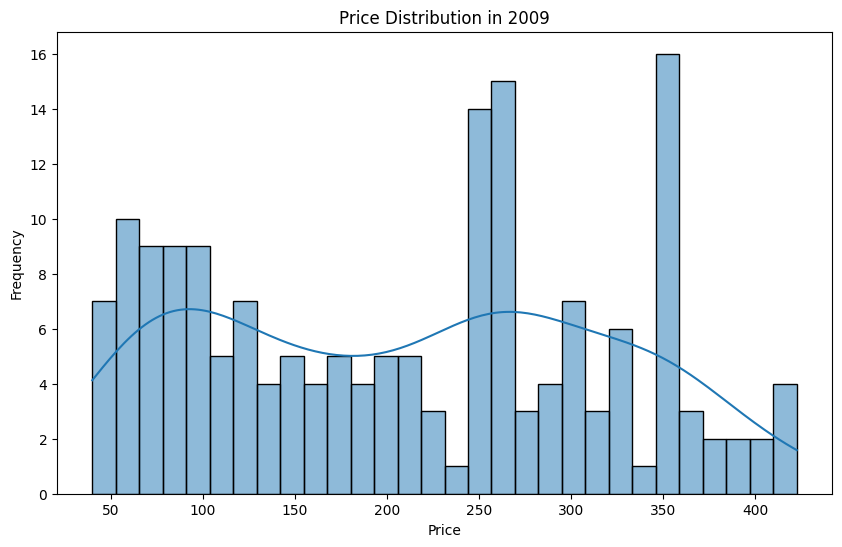

In [ ]:
#Filter data for the year 2009
Data2009 = CombinedData[CombinedData['year'] == 2009]

#Calculate IQR for price
Q1 = Data2009['price'].quantile(0.25)
Q3 = Data2009['price'].quantile(0.75)
IQR = Q3 - Q1

#Define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Identify and Display outliers
outliers = Data2009[(Data2009['price'] < lower_bound) | (Data2009['price'] > upper_bound)]
print("Outliers in 2009:\n", outliers)

#Plot the price distribution
plt.figure(figsize=(10, 6))
sns.histplot(Data2009['price'], kde=True, bins=30)
plt.title('Price Distribution in 2009')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#Explantions in the document

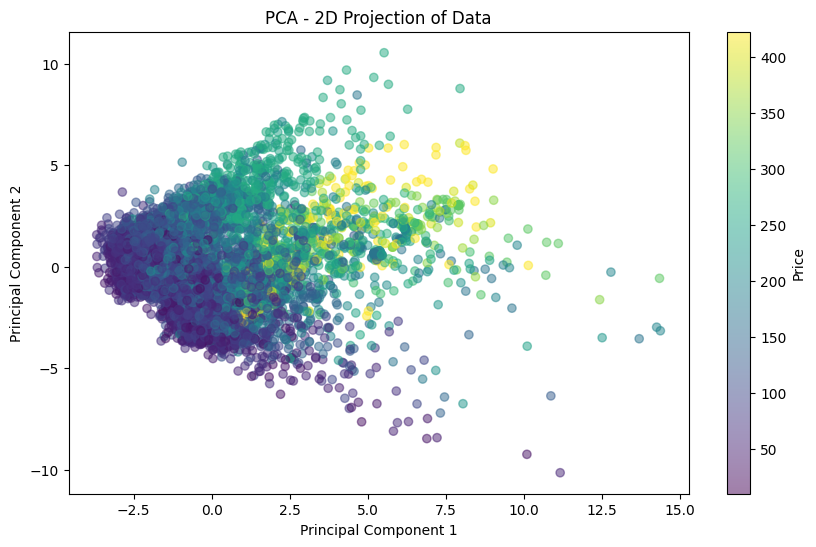

In [ ]:
#Application of dimensionality reduction technique: PCA (Principal Component Analysis)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Select numerical columns and scale
NumericalData = CombinedData[NumericalColumns]
Scaler = StandardScaler()
ScaledData = Scaler.fit_transform(NumericalData)

#Apply PCA (creating 2D data)
pca = PCA(n_components=2)
PcaResult = pca.fit_transform(ScaledData)

#Visualizilation
plt.figure(figsize=(10, 6))
plt.scatter(PcaResult[:, 0], PcaResult[:, 1], c=CombinedData['price'], cmap='viridis', alpha=0.5)
plt.title("PCA - 2D Projection of Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Price')
plt.show()